In [1]:
import numpy as np
import os
import skimage
import utils as imgTrans
import fileIO as importFile
import matplotlib.pyplot as plt
import mlUtils as mL
import re

curPath = '../../data/processed/'

for dir in os.listdir(curPath):
    print(dir)
    maxList = np.zeros((1,32*32))
    for file in os.listdir(curPath+dir):
        a = np.load(curPath+dir+'/'+file)
        b = np.reshape(a,(1,32*32))
        tmpList = np.maximum(maxList,b)
        maxList = tmpList
    tmp = np.reshape(maxList,(32,32))
    #plt.imshow(tmp)
    #plt.show()
    np.save('../../data/newProcessedAll/'+dir,tmp)
    for i in range(0,10):
        hFlipRand = np.random.rand(1) < .5
        vFlipRand = np.random.rand(1) < .5
    
        degree = np.random.randint(0,360)
        
        tmp2 = skimage.transform.rotate(tmp,degree)

        if hFlipRand:
            tmp2= np.flip(tmp2,axis=1)
        if vFlipRand:
            tmp2= np.flip(tmp2,axis=0)
        np.save('../../data/newProcessedAll/'+dir[:-4]+'_____'+str(i)+'.tif',tmp2)        

In [8]:
fToGDic = {}
gDic = {}
with open('../../image_stack_to_genus.tsv') as file1:
    line1=file1.readline().strip()
    while line1:
        line1_sp = line1.split('\t')
        fToGDic[line1_sp[0]] = line1_sp[1]
        
        if line1_sp[1] not in gDic:
            gDic[line1_sp[1]] = 1
        else:
            gDic[line1_sp[1]] = gDic[line1_sp[1]] + 1
        line1=file1.readline().strip()
        
oneHotDic = {}
cnt = 0   
for key in gDic:
    oneHotDic[key] = cnt
    cnt = cnt + 1
numLabel = cnt
print(gDic)
print(oneHotDic)

{'kuruna': 28, 'ampelocalamus': 21, 'sinobambusa': 8, 'thamnocalamus': 20, 'shibataea': 20, 'pleioblastus': 20, 'phyllostachys': 10, 'chimonocalamus': 32, 'bergbambos': 31, 'arundinaria': 18, 'chimonobambusa': 21, 'guadua': 31, 'dinochloa': 38, 'macluorchloa': 8, 'otatea': 40, 'racemo': 3, 'chusquea': 2, 'arthrostylidium': 3, 'bambusa': 8, 'hickelia': 7, 'davidsea': 8, 'racemobambos': 4, 'merostachys': 7, 'meloncanna': 14, 'nastus': 23, 'buerguesiochloa': 33, 'diandrolyra': 53, 'eremites': 37, 'lithacne': 44, 'sucrea': 42, 'raddia': 36, 'olyra': 24, 'pariana': 44, 'leersia': 4, 'oryza': 29, 'zizaniopsis': 8, 'zizania': 20, 'humbertochloa': 26, 'phyllorachis': 24, 'ehrharta': 28, 'streptogyna': 16}
{'kuruna': 0, 'ampelocalamus': 1, 'sinobambusa': 2, 'thamnocalamus': 3, 'shibataea': 4, 'pleioblastus': 5, 'phyllostachys': 6, 'chimonocalamus': 7, 'bergbambos': 8, 'arundinaria': 9, 'chimonobambusa': 10, 'guadua': 11, 'dinochloa': 12, 'macluorchloa': 13, 'otatea': 14, 'racemo': 15, 'chusquea

In [11]:
curPath = '../../data/newProcessedAll//'

numLayers = 1
numCols = 32
numRows = 32
tX = np.empty((numLayers*numCols*numRows))
tY = np.empty((1,numLabel))
vX = np.empty((numLayers*numCols*numRows))
vY = np.empty((1,numLabel))
testX = np.empty((numLayers*numCols*numRows))
testY = np.empty((1,numLabel))

for file in os.listdir(curPath):
    a = np.load(curPath+file)
    tmp = np.reshape(a,(1,32*32))
    
    tFile = file[:-4]
    t2File = re.sub('_____\d','',tFile)

    species = fToGDic[t2File]

    randNum = np.random.rand((1))
    
    if randNum < .8:
        tX = np.vstack((tX,tmp))
            
        tmp = np.zeros((1,numLabel))
        curLabel = oneHotDic[species]
        tmp[0][curLabel] = 1
        tY = np.vstack((tY,tmp))
    elif randNum < .9:
        vX = np.vstack((vX,tmp))
            
        tmp = np.zeros((1,numLabel))
        curLabel = oneHotDic[species]
        tmp[0][curLabel] = 1
        vY = np.vstack((vY,tmp))
    else:
        testX = np.vstack((testX,tmp))
            
        tmp = np.zeros((1,numLabel))
        curLabel = oneHotDic[species]
        tmp[0][curLabel] = 1
        testY = np.vstack((testY,tmp))

In [12]:
tX = np.delete(tX, (0), axis=0)
tY = np.delete(tY, (0), axis=0)
vX = np.delete(vX, (0), axis=0)
vY = np.delete(vY, (0), axis=0)
testX = np.delete(testX, (0), axis=0)
testY = np.delete(testY, (0), axis=0)

In [15]:
lambRange = [.000001,.00001,.0001,.001,.01,.1,1,10,100,1000]
for curLam in lambRange:
    linReg = mL.linear()
    wHat = linReg.train(tX,tY,curLam)
    
    print("lambda: " +str(curLam))
    Y_hat = linReg.predict(wHat, tX)
    print("train: "+str(mL.accuracy(tY, Y_hat)))

    Y_hat = linReg.predict(wHat, vX)
    print("validation: "+str(mL.accuracy(vY, Y_hat)))

    Y_hat = linReg.predict(wHat, testX)
    print("test: "+str(mL.accuracy(testY, Y_hat)))
    print("")

lambda: 1e-06
train: 0.58929956061
validation: 0.160120845921
test: 0.140147523709

lambda: 1e-05
train: 0.58929956061
validation: 0.160120845921
test: 0.140147523709

lambda: 0.0001
train: 0.58917032825
validation: 0.160120845921
test: 0.140147523709

lambda: 0.001
train: 0.588524166451
validation: 0.161127895267
test: 0.139093782929

lambda: 0.01
train: 0.587619539933
validation: 0.159113796576
test: 0.140147523709

lambda: 0.1
train: 0.581416386663
validation: 0.159113796576
test: 0.147523709168

lambda: 1
train: 0.550012923236
validation: 0.166163141994
test: 0.161222339305

lambda: 10
train: 0.46446110106
validation: 0.178247734139
test: 0.162276080084

lambda: 100
train: 0.329284052727
validation: 0.188318227593
test: 0.163329820864

lambda: 1000
train: 0.203540966658
validation: 0.140986908359
test: 0.13593256059



In [14]:
print (numLabel)
print(1/numLabel)

41
0.024390243902439025


In [16]:
#logistic regression
logReg = mL.logistic()

In [54]:
step_size = 0.01
lam = 1
eps = 0.00000001
maxiter = 1000

In [ ]:
outputList = []
print("Num Label: " +str(len(tY[0])))
for i in range(0,len(tY[0])):
    newtY = mL.oneHotToLogLabels(tY,i)
    newtestY = mL.oneHotToLogLabels(testY,i)

    output = logReg.reg_gradient_desc(tX, newtY, testX, newtestY, step_size, lam, eps, maxiter)
    outputList.append(output)
    
    if i%10 == 0:
        print(i)

Num Label: 41
maximum iterations reached
0
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
10
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
20
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
maximum iterations reached
30


In [53]:
# train accuracy
yVAll = np.zeros((tX.shape[0],len(tY[0])))
for i in range(0,len(outputList)):
    curOutput = outputList[i]
    W = curOutput[0] #weights
    #print(W)
    b = curOutput[1] #offsets

    yHat = b + tX.dot(W)
    yVAll[:,i] = yHat[:,0]
    
tmp = np.argmax(yVAll,axis=1)

tot = 0.0
cor = 0.0
for i in range(0,len(tmp)):
    if tmp[i] == np.nonzero(tY[i])[0][0]:
        cor = cor + 1
    tot = tot + 1
print(cor/tot)

0.06293615921426725


In [49]:
# val accuracy
yVAll = np.zeros((vX.shape[0],len(vY[0])))
for i in range(0,len(outputList)):
    curOutput = outputList[i]
    W = curOutput[0] #weights
    #print(W)
    b = curOutput[1] #offsets

    yHat = b + vX.dot(W)
    yVAll[:,i] = yHat[:,0]
    
tmp = np.argmax(yVAll,axis=1)

tot = 0.0
cor = 0.0
for i in range(0,len(tmp)):
    if tmp[i] == np.nonzero(vY[i])[0][0]:
        cor = cor + 1
    tot = tot + 1
print(cor/tot)

0.12084592145015106


In [50]:
# test accuracy
yVAll = np.zeros((testX.shape[0],len(testY[0])))
for i in range(0,len(outputList)):
    curOutput = outputList[i]
    W = curOutput[0] #weights
    #print(W)
    b = curOutput[1] #offsets

    yHat = b + testX.dot(W)
    yVAll[:,i] = yHat[:,0]
    
tmp = np.argmax(yVAll,axis=1)
#for i in range(0,len(tmp)):
#    print(tmp[i])

tot = 0.0
cor = 0.0
for i in range(0,len(tmp)):
    if tmp[i] == np.nonzero(testY[i])[0][0]:
        cor = cor + 1
    tot = tot + 1
print(cor/tot)

0.136986301369863


In [43]:
output = outputList[15]
W = output[0] #weights
b = output[1] #offsets
likelihoods = output[2] #series of likelihoods per gradient descent step
test_likelihoods = output[3] #series of test data likelihoods per gradient descent steps
errs = 1.0 - np.array(output[4]) #series of errors
test_errs = 1.0 - np.array(output[5]) #series of test errors

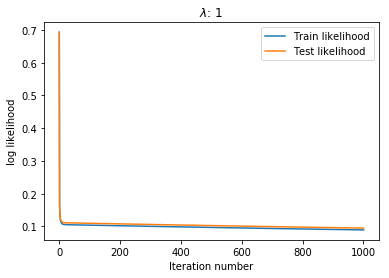

In [44]:
#likelihoods
iters = len(likelihoods)

plt.plot(range(iters), likelihoods, label="Train likelihood")
plt.plot(range(iters), test_likelihoods, label="Test likelihood")
plt.xlabel("Iteration number")
plt.ylabel("log likelihood")
plt.title("$\lambda$: " + str(lam))
plt.legend()
plt.show()

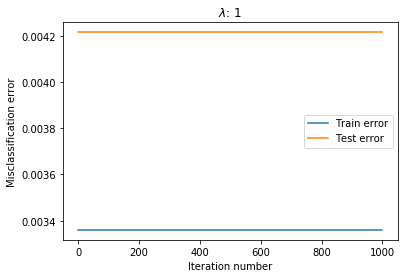

In [45]:
#accuracies
iters = len(errs)

plt.plot(range(iters), errs, label="Train error")
plt.plot(range(iters), test_errs, label="Test error")
plt.xlabel("Iteration number")
plt.ylabel("Misclassification error")
plt.title("$\lambda$: " + str(lam))
plt.legend()
plt.show()

print(len(outputList))
#for i in range(0,len(tY[0])):
for i in range(20,22):
    i = 20
    newtY = mL.oneHotToLogLabels(tY,i)
    newtestY = mL.oneHotToLogLabels(testY,i)
    a= newtY
    
    i = 33
    newtY = mL.oneHotToLogLabels(tY,i)
    newtestY = mL.oneHotToLogLabels(testY,i)
    b = newtY
    break
q=np.equal(a,b)
print(np.unique(q))

In [ ]:
#stochastic gradient descent

In [ ]:
step_size = 0.01
lam = 0.1
eps = 0.001
maxiter = 100
batch_size = 1

In [ ]:
output = logReg.stoch_reg_gradient_desc(tX, newtY, testX, newtestY, step_size, lam, eps, maxiter, batch_size)

In [ ]:
W = output[0]
b = output[1]
likelihoods = output[2]
test_likelihoods = output[3]
errs = 1.0 - np.array(output[4])
test_errs = 1.0 - np.array(output[5])

In [ ]:
#likelihoods
iters = len(likelihoods)

plt.plot(range(iters), likelihoods, label="Train likelihood")
plt.plot(range(iters), test_likelihoods, label="Test likelihood")
plt.xlabel("Iteration number")
plt.ylabel("log likelihood")
plt.title("$\lambda$: " + str(lam))
plt.legend()
plt.show()

In [ ]:
#accuracies
iters = len(errs)

plt.plot(range(iters), errs, label="Train error")
plt.plot(range(iters), test_errs, label="Test error")
plt.xlabel("Iteration number")
plt.ylabel("Misclassification error")
plt.title("$\lambda$: " + str(lam))
plt.legend()
plt.show()